# In-Depth EDA

This notebook contains an in-depth EDA upon a dataset in e-commerce industry.

<div class="list-group" id="list-tab" role="tablist">

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>Contents</center></h2>

1. [Motivation Overview]
2. [Libraries]
3. [Load Datasets] 
4. [Tabular Exploration] 
5. [Image Title Exploration]
6. [Label Group Exploration] 
7. [Basic Image Exploration]
8. [Intermediate Image Exploration] 
9. [Advanced Image Exploration]
10. [References]

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>Motivation Overview</center></h2>

### Background Description

Retail companies use a variety of methods to assure customers that their products are the cheapest. Among them is product matching, which allows a company to offer products at rates that are competitive to the same product sold by another retailer. To perform these matches automatically requires a thorough machine learning approach, which is where  data science skills could help.

Two different images of similar wares may represent the same product or two completely different items. Retailers want to avoid misrepresentations and other issues that could come from conflating two dissimilar products. Currently, a combination of deep learning and traditional machine learning analyzes image and text information to compare similarity. But major differences in images, titles, and product descriptions prevent these methods from being entirely effective.

In this setting, I will apply my machine learning skills to build a model that predicts which items are the same products.

### Data Description

Finding near-duplicates in large datasets is an important problem for many online businesses. In the case of this project, everyday users can upload their own images and write their own product descriptions, adding an extra layer of challenge. Our task is to identify which products have been posted repeatedly. The differences between related products may be subtle while photos of identical products may be wildly different!

Note that only the first few rows/images of the test set are published; the remainder are not available, but expect to find roughly 70,000 images in the hidden test set. So, I will use the few test rows and images that are provided are intended to illustrate the hidden test set format and folder structure.

#### Files

***\[train/test\].csv*** - the training set metadata. Each row contains the data for a single posting. Multiple postings might have the exact same image ID, but with different titles or vice versa.

- `posting_id` - the ID code for the posting.

- `image` - the image id/md5sum.

- `image_phash` - a perceptual hash of the image.

- `title` - the product description for the posting.

- `label_group` - ID code for all postings that map to the same product. Not provided for the test set.

***\[train/test\]images*** - the images associated with the postings.

***sample_submission.csv*** - a sample submission file in the correct format.

- `posting_id` - the ID code for the posting.

- `matches` - Space delimited list of all posting IDs that match this posting. Posts always self-match. Group sizes were capped at 50, so there's no need to predict more than 50 matches.

### Evaluation Criteria
Product-matching result will be evaluated based on their mean [F1 score](https://en.wikipedia.org/wiki/F1_score). The mean is calculated in a sample-wise fashion, meaning that an F1 score is calculated for every predicted row, then averaged.

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>Libraries</center></h2>

In [2]:
import warnings
warnings.simplefilter("ignore")

import numpy as np
# np.random.bit_generator = np.random._bit_generator
import pandas as pd

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]=r"C:\Users\xxxli\Downloads\eda-sample-308820-e2832e3a80ea.json"
from google.cloud import bigquery

import plotly.express as px

import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from wordcloud import WordCloud, STOPWORDS

#Text Color
from termcolor import colored

#Data Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

#NLP
from sklearn.feature_extraction.text import CountVectorizer

#WordCloud
from wordcloud import WordCloud, STOPWORDS

#Text Processing
import re
import nltk
# nltk.download('popular')

#Language Detection
import langdetect

#Sentiment
from textblob import TextBlob

#ner
import spacy

#Vectorizer
from sklearn import feature_extraction, manifold

#Word Embedding
import gensim.downloader as gensim_api

#Topic Modeling
import gensim

In [3]:
#!pip install -e git+https://github.com/SohierDane/BigQuery_Helper#egg=bq_helper
import sys
sys.path.append("c:\\Users\\xxxli\\Desktop\\ResumeProjects\\EDA_Ecommerce_Images\\src\\bq-helper\\")  
# path contains python_file.py

from bq_helper import BigQueryHelper

In [4]:
#!pip install "dask[complete]" --user
from dask import bag, diagnostics 

In [5]:
import hvplot.pandas  # custom install
from glob import glob
from urllib import request
import missingno as msno
from PIL import Image

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>Load Datasets</center></h2>

### CSV Files

In [7]:
train = pd.read_csv(r'EDA_Ecommerce_Images\datasets\train.csv')
test = pd.read_csv(r'EDA_Ecommerce_Images\datasets\test.csv')
sample = pd.read_csv(r'EDA_Ecommerce_Images\datasets\sample_submission.csv')

### Image Files

In [8]:
#Image Folder Paths
train_jpg_directory = r'EDA_Ecommerce_Images\datasets\train_images'
test_jpg_directory = r'EDA_Ecommerce_Images\datasets\test_images'

In [9]:
def getImagePaths(path):
    """
    Function to Combine Directory Path with individual Image Paths
    
    parameters: path(string) - Path of directory
    returns: image_names(string) - Full Image Path
    """
    image_names = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
    return image_names

In [10]:
#Get complete image paths for train and test datasets
train_images_path = getImagePaths(train_jpg_directory)
test_images_path = getImagePaths(test_jpg_directory)

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>Tabular Exploration</center></h2>

### Dataset Head

In [11]:
train.head()

posting_id                                 image       image_phash  \
0   train_129225211  0000a68812bc7e98c42888dfb1c07da0.jpg  94974f937d4c2433   
1  train_3386243561  00039780dfc94d01db8676fe789ecd05.jpg  af3f9460c2838f0f   
2  train_2288590299  000a190fdd715a2a36faed16e2c65df7.jpg  b94cb00ed3e50f78   
3  train_2406599165  00117e4fc239b1b641ff08340b429633.jpg  8514fc58eafea283   
4  train_3369186413  00136d1cf4edede0203f32f05f660588.jpg  a6f319f924ad708c   

                                               title  label_group  
0                          Paper Bag Victoria Secret    249114794  
1  Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...   2937985045  
2        Maling TTS Canned Pork Luncheon Meat 397 gr   2395904891  
3  Daster Batik Lengan pendek - Motif Acak / Camp...   4093212188  
4                  Nescafe \xc3\x89clair Latte 220ml   3648931069

In [12]:
test.head()

posting_id                                 image       image_phash  \
0  test_2255846744  0006c8e5462ae52167402bac1c2e916e.jpg  ecc292392dc7687a   
1  test_3588702337  0007585c4d0f932859339129f709bfdc.jpg  e9968f60d2699e2c   
2  test_4015706929  0008377d3662e83ef44e1881af38b879.jpg  ba81c17e3581cabe   

                                               title  
0  Edufuntoys - CHARACTER PHONE ada lampu dan mus...  
1  (Beli 1 Free Spatula) Masker Komedo | Blackhea...  
2   READY Lemonilo Mie instant sehat kuah dan goreng

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34250 entries, 0 to 34249
Data columns (total 5 columns):
posting_id     34250 non-null object
image          34250 non-null object
image_phash    34250 non-null object
title          34250 non-null object
label_group    34250 non-null int64
dtypes: int64(1), object(4)
memory usage: 1.3+ MB


This shows us that there are no nan values in the training dataset. One less thing to worry about!

### Dataset Size

In [14]:
print(f"Training Dataset Shape: {colored(train.shape, 'yellow')}")
print(f"Test Dataset Shape: {colored(test.shape, 'yellow')}")

Training Dataset Shape: (34250, 5)
Test Dataset Shape: (3, 4)


### Column-wise Unique Values

In [15]:
for col in train.columns:
    print(col + ":" + colored(str(len(train[col].unique())), 'yellow'))

posting_id:34250
image:32412
image_phash:28735
title:33117
label_group:11014


Thus, only the `posting_id` columns has unique values. Rest all the columns have duplicate values. 

### Number of Images in Each Directory

In [16]:
print(f"Number of train images: {colored(len(train_images_path), 'yellow')}")
print(f"Number of test images:  {colored(len(test_images_path), 'yellow')}")

Number of train images: 32412
Number of test images:  3


In [17]:
def display_multiple_img(images_paths, rows, cols):
    """
    Function to Display Images from Dataset.
    
    parameters: images_path(string) - Paths of Images to be displayed
                rows(int) - No. of Rows in Output
                cols(int) - No. of Columns in Output
    """
    figure, ax = plt.subplots(nrows=rows,ncols=cols,figsize=(16,8) )
    for ind,image_path in enumerate(images_paths):
        image=cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        try:
            ax.ravel()[ind].imshow(image)
            ax.ravel()[ind].set_axis_off()
        except:
            continue;
    plt.tight_layout()
    plt.show()

### Train Images

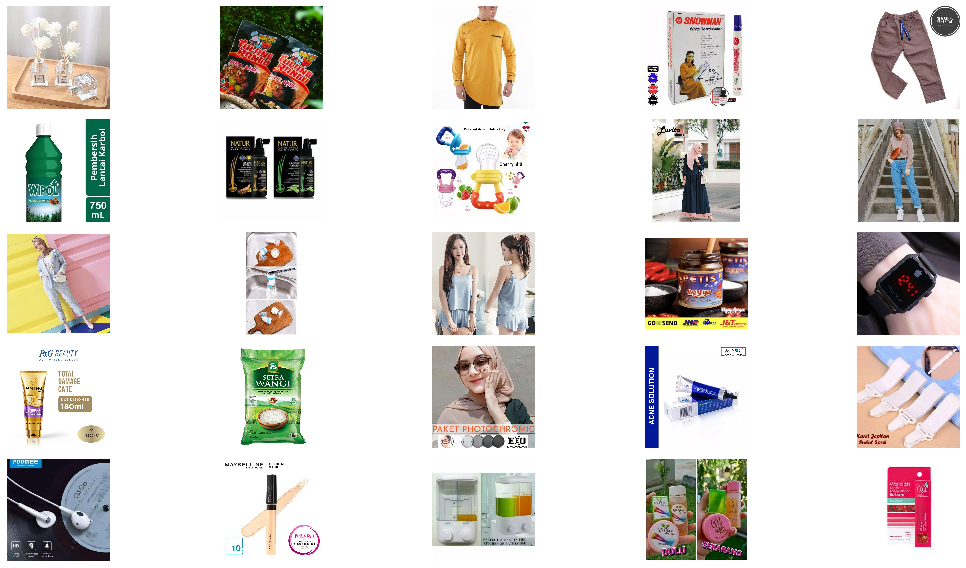

In [18]:
display_multiple_img(train_images_path[100:150], 5, 5)

### Test Images

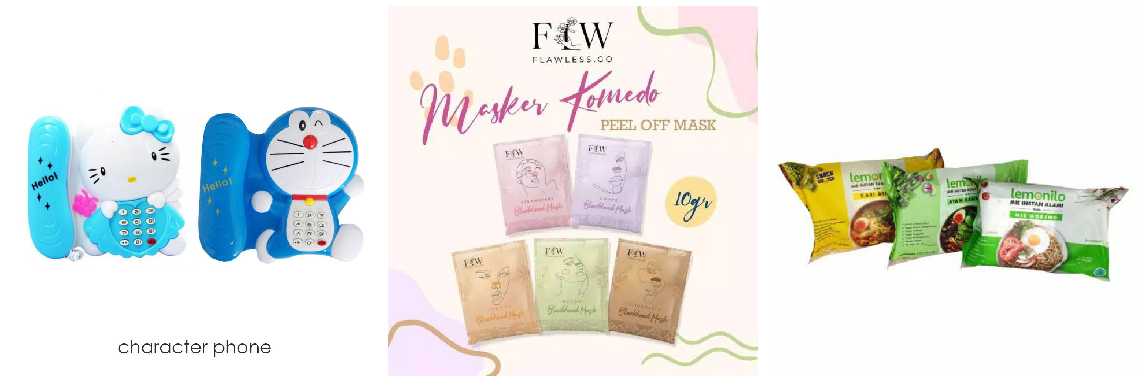

In [19]:
display_multiple_img(test_images_path, 1, 3)

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>Image Title Exploration</center></h2>

### Wordcloud

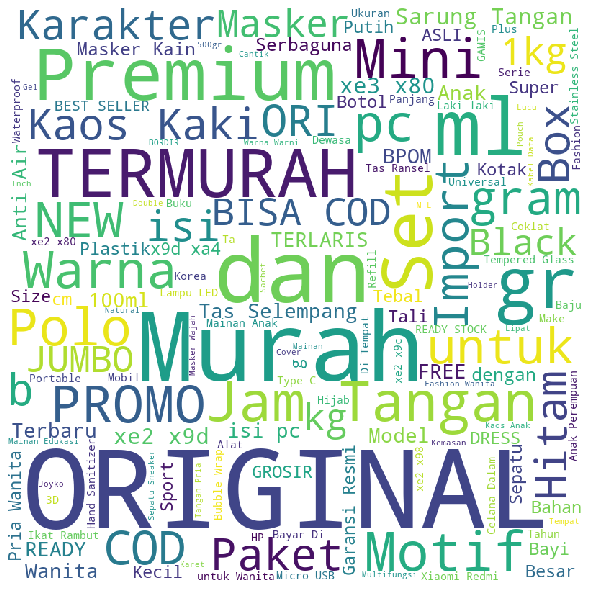

In [20]:
stopwords = set(STOPWORDS) 
wordcloud = WordCloud(width = 800, 
                      height = 800,
                      background_color ='white',
                      min_font_size = 10,
                      stopwords = stopwords,).generate(' '.join(train['title'])) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

In [21]:
train.head()

posting_id                                 image       image_phash  \
0   train_129225211  0000a68812bc7e98c42888dfb1c07da0.jpg  94974f937d4c2433   
1  train_3386243561  00039780dfc94d01db8676fe789ecd05.jpg  af3f9460c2838f0f   
2  train_2288590299  000a190fdd715a2a36faed16e2c65df7.jpg  b94cb00ed3e50f78   
3  train_2406599165  00117e4fc239b1b641ff08340b429633.jpg  8514fc58eafea283   
4  train_3369186413  00136d1cf4edede0203f32f05f660588.jpg  a6f319f924ad708c   

                                               title  label_group  
0                          Paper Bag Victoria Secret    249114794  
1  Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...   2937985045  
2        Maling TTS Canned Pork Luncheon Meat 397 gr   2395904891  
3  Daster Batik Lengan pendek - Motif Acak / Camp...   4093212188  
4                  Nescafe \xc3\x89clair Latte 220ml   3648931069

### Basic NLP 

In [22]:
def preprocess_text(text, flg_stemm=False, flg_lemm=True):

    lst_stopwords = nltk.corpus.stopwords.words("english")
    
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()    
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [23]:
#Clean Address
train["clean_title"] = train["title"].apply(lambda x: preprocess_text(x, flg_stemm=False, flg_lemm=True, ))

In [24]:
#Length of Title
train['clean_title_len'] = train['clean_title'].apply(lambda x: len(x))

#Word Count
train['clean_title_word_count'] =train["clean_title"].apply(lambda x: len(str(x).split(" ")))

#Character Count
train['clean_title_char_count'] = train["clean_title"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))

#Average Word Length
train['clean_title_avg_word_length'] = train['clean_title_char_count'] / train['clean_title_word_count']

In [25]:
train.head()

posting_id                                 image       image_phash  \
0   train_129225211  0000a68812bc7e98c42888dfb1c07da0.jpg  94974f937d4c2433   
1  train_3386243561  00039780dfc94d01db8676fe789ecd05.jpg  af3f9460c2838f0f   
2  train_2288590299  000a190fdd715a2a36faed16e2c65df7.jpg  b94cb00ed3e50f78   
3  train_2406599165  00117e4fc239b1b641ff08340b429633.jpg  8514fc58eafea283   
4  train_3369186413  00136d1cf4edede0203f32f05f660588.jpg  a6f319f924ad708c   

                                               title  label_group  \
0                          Paper Bag Victoria Secret    249114794   
1  Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...   2937985045   
2        Maling TTS Canned Pork Luncheon Meat 397 gr   2395904891   
3  Daster Batik Lengan pendek - Motif Acak / Camp...   4093212188   
4                  Nescafe \xc3\x89clair Latte 220ml   3648931069   

                                         clean_title  clean_title_len  \
0                          paper bag victoria secret               25   
1  double tape 3m vhb 12 mm x 45 original double ...               55   
2         maling tt canned pork luncheon meat 397 gr               42   
3  daster batik lengan pendek motif acak campur l...               89   
4                    nescafe xc3x89clair latte 220ml               31   

   clean_title_word_count  clean_title_char_count  clean_title_avg_word_length  
0                       4                      22                     5.500000  
1                      12                      44                     3.666667  
2                       8                      35                     4.375000  
3                      13                      77                     5.923077  
4                       4                      28                     7.000000

### Distribution Plots

In [26]:
def plot_distribution(x, title):

    fig = px.histogram(
    train, 
    x = x,
    width = 800,
    height = 500,
    title = title
    )
    
    fig.show()

In [27]:
plot_distribution(x = 'clean_title_len', title = 'Title Length Distribution')

In [28]:
plot_distribution(x = 'clean_title_word_count', title = 'Word Count Distribution')

In [29]:
plot_distribution(x = 'clean_title_char_count', title = 'Character Count Distribution')

In [30]:
plot_distribution(x = 'clean_title_avg_word_length', title = 'Average Word Length Distribution')

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>Label Group Exploration</center></h2>

### Count of Unique Label Groups

In [31]:
print(f"No. of Unique Label Groups: {colored(train.label_group.nunique(), 'yellow')}")

No. of Unique Label Groups: 11014


### Image Label Groups by No. of Images

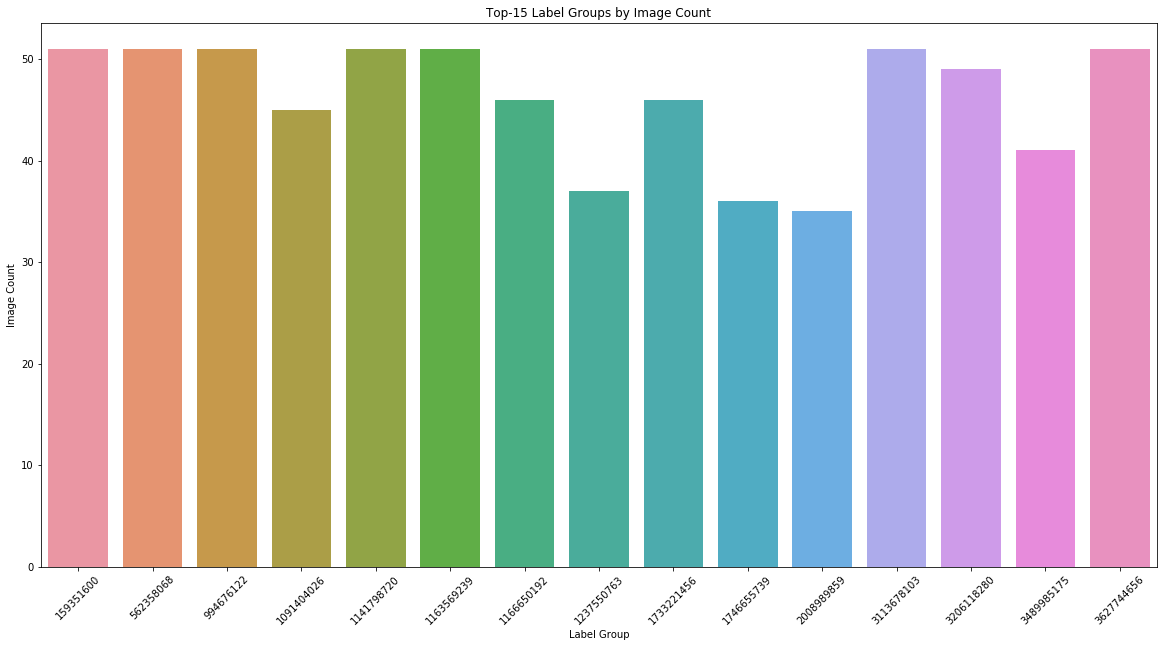

In [32]:
top10_names = train['label_group'].value_counts().index.tolist()[:15]
top10_values = train['label_group'].value_counts().tolist()[:15]

plt.figure(figsize=(20, 10))
sns.barplot(x=top10_names, y=top10_values)
plt.xticks(rotation=45)
plt.xlabel("Label Group")
plt.ylabel("Image Count")
plt.title("Top-15 Label Groups by Image Count")
plt.show()

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>Basic Image Exploration</center></h2>

### Dimensions and 2D Histograms

Just look at image dimensions, confirm it's 3 band (RGB), byte scaled (0-255).

In [58]:
first = cv2.imread(train_images_path[0])
dims = np.shape(first)
print(dims)

(1024, 1024, 3)


In [34]:
np.min(first), np.max(first)

(0, 255)


For any image specific classification, clustering, etc. transforms we'll want to collapse spatial dimensions so that we have a matrix of pixels by color channels.

In [35]:
pixel_matrix = np.reshape(first, (dims[0] * dims[1], dims[2]))
print(np.shape(pixel_matrix))

(1048576, 3)


Scatter plots are a go to to look for clusters and separatbility in the data, but these are busy and don't reveal density well, so we switch to using 2d histograms instead. The data between bands is really correlated, typical with visible imagery and why most satellite image analysts prefer to at least have near infrared values.

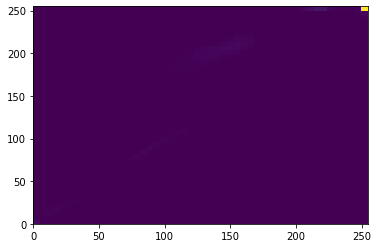

In [36]:
_ = plt.hist2d(pixel_matrix[:,1], pixel_matrix[:,2], bins=(50,50))

In [37]:
fifth = cv2.imread(train_images_path[4])
dims = np.shape(fifth)
pixel_matrix5 = np.reshape(fifth, (dims[0] * dims[1], dims[2]))

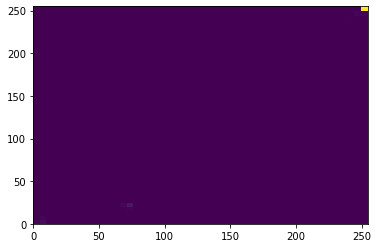

In [38]:
_ = plt.hist2d(pixel_matrix5[:,1], pixel_matrix5[:,2], bins=(50,50))

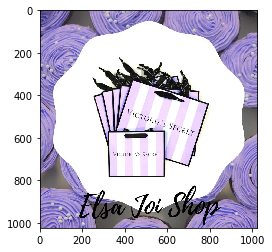

In [39]:
plt.imshow(first)

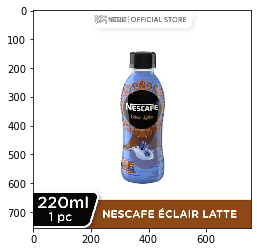

In [40]:
plt.imshow(fifth)

-----------------------
see part II
